## Definitive proof that this a marginal gain for 'Average Price' small time windows

We use average traded price since that is our benchmark comparison (not percentage returns)

In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from datetime import datetime
from dateutil import parser
from scipy.stats import norm, t
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

sns.set(rc={'figure.figsize':(11.7,8.27)})

def getData(fname,ccy):
    df = pd.read_csv('/home/ian/Downloads/'+fname,skiprows=0)
    #df['date']=pd.to_datetime(df['date'])
    df['date'] = df['unix'].astype('int32')
    df['date'] = pd.to_datetime(df['unix'], unit='ms')
    df[ccy]=df.close
    df.rename_axis(None, axis = 1)
    df.set_index(['date'])
    df.sort_index(inplace=True,ascending=False)
    df.drop(columns=['unix','open','high','low','close','symbol','tradecount','Volume USDT'],inplace=True,errors='ignore')    
    return df

eth = getData('Binance_ETHUSDT_minute.csv','eth')

eth.reset_index(inplace=True)
eth.date = pd.to_datetime(eth.date)
eth.set_index('date')
eth['ret'] = eth.eth.pct_change()
eth['csum'] = eth.eth.pct_change().cumsum()
eth.dropna(inplace=True,how='any')
eth.rename(columns={"eth": "price"},inplace=True)

def wma(data,window):
    w = np.arange(1,window+1) 
    return data.rolling(window).apply(lambda prices: np.dot(prices, w)/w.sum(), raw=True)
    
def hma(datain,wind=6):
    halfwind = int(wind / 2)   
    datain.dropna(inplace=True,how='any')
    datain['wma1'] = wma(datain.price,halfwind)
    datain['wma2'] = wma(datain.price,wind)
    datain['hma'] = wma(2 * datain.wma1-datain.wma2, int(np.sqrt(wind)))    
    #datain['hmadiff'] = datain.hma.pct_change()
    eth.dropna(inplace=True,how='any')
    #datain['pos'] = (datain.hmadiff > 0.01) * 1.0  
    #datain['pos'] = (datain.pos >= 1) * 1.0  
    #datain['strat'] = datain['pos'].shift(1) * datain['ret']
    return datain

### Data looks good, lets take a small 1 hour block in the sample set 
### and plot price against HMA(5mins)...

<AxesSubplot:>

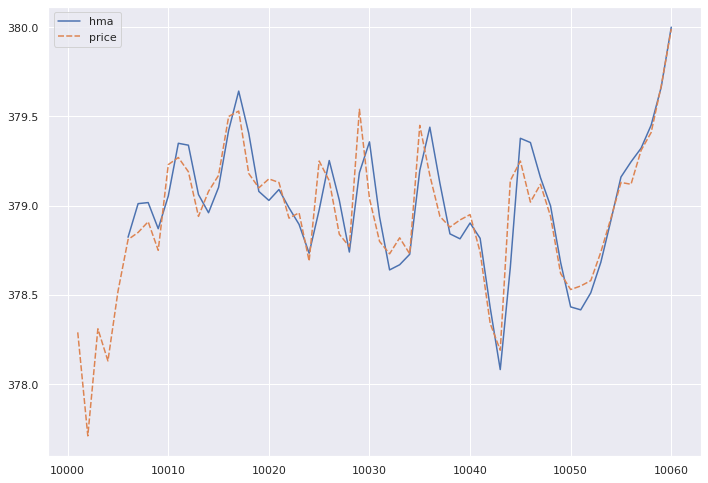

In [5]:
prices = eth.copy()
prices = prices[10000:10060]
df = hma(prices,5)
sns.lineplot(data=[df.hma,df.price])

Create a trading pattern in the dataset. Only trade when (price > hma price) this would be for a SELL as we want to get the highest average price overall

In [14]:
TSIZE=1000
df['trade']=0
#df['remain']=TSIZE
df['pos']=0
df.trade=(df.price>df.hma)*1
df.pos=df.trade.cumsum()
df['tpos']=df.pos.cumsum()
#df.remain=TSIZE-df.pos
df['fact']=df.trade*df.price
print("Ave Price using only swing trading :", df.fact.sum()/df.pos.iloc[-1])

Ave Price using only swing trading : 378.98807692307696


In [12]:
df.tail(10)

,index,date,Volume ETH,price,ret,csum,wma1,wma2,hma,trade,remain,pos,tpos,fact,ntpos,ntfact
10051,248895,2020-09-18 20:11:00,649.69274,378.55,0.000053,0.031856,378.543333,378.648667,378.416222,1,978,22,485,378.55,1,378.55
10052,248894,2020-09-18 20:12:00,429.34628,378.58,0.000079,0.031935,378.570000,378.591333,378.511778,1,977,23,508,378.58,1,378.58
10053,248893,2020-09-18 20:13:00,270.09758,378.74,0.000423,0.032358,378.686667,378.623333,378.682889,1,976,24,532,378.74,1,378.74
10054,248892,2020-09-18 20:14:00,296.43896,378.93,0.000502,0.032859,378.866667,378.732000,378.917556,1,975,25,557,378.93,1,378.93
10055,248891,2020-09-18 20:15:00,502.08341,379.13,0.000528,0.033387,379.063333,378.886667,379.160444,0,975,25,582,0.00,1,379.13
10056,248890,2020-09-18 20:16:00,301.53070,379.12,-0.000026,0.033361,379.123333,378.998000,379.245778,0,975,25,607,0.00,1,379.12
10057,248889,2020-09-18 20:17:00,184.71856,379.31,0.000501,0.033862,379.246667,379.134667,379.322000,0,975,25,632,0.00,1,379.31
10058,248888,2020-09-18 20:18:00,314.05362,379.41,0.000264,0.034126,379.376667,379.256000,379.451111,0,975,25,657,0.00,1,379.41
10059,248887,2020-09-18 20:19:00,504.39663,379.67,0.000685,0.034811,379.583333,379.419333,379.664000,1,974,26,683,379.67,1,379.67
10060,248886,2020-09-18 20:20:00,685.02981,379.99,0.000843,0.035654,379.883333,379.640000,380.000222,0,974,26,709,0.00,1,379.99


Lets compare this to just trading every minute

In [13]:
df['ntpos']=1
df['ntfact']=df.price*df.ntpos
print("Ave Price by just using equal block trading:", df.ntfact.sum()/df.ntpos.sum())

Ave Price by just using equal block trading: 378.94366666666673


## Overall difference is ln( 378.98807692307696 / 378.94366666666673 )

In [10]:
# in percentage terms....
100 * math.log(378.98807692307696 / 378.94366666666673)

0.01171880102309009

## So for the 0.0117% improvment, the whole outcome relies on the ratio of swing trade to equal block trades. If the ratio of swing trade size to equal block trade size is too high, we run the risk of trading too early or not enough given the volitility.